In [1]:
import pandas as pd

df = pd.read_csv('my_data.csv')
df.drop(['entry_id', 'pos1', 'pos2'], axis = 1, inplace = True)

In [2]:
len(df)

463068

In [3]:
x = df['bread1'].values.tolist()
y = df['bread2'].values.tolist()
corpus = x + y

In [4]:
len(corpus)

926136

In [5]:
import re
import nltk
nltk.download('stopwords')
sw_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanmesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# removing all the special characters
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

def preprocess(x):
    s = ''
    x = re.sub('\W+', ' ', x)
    for data in x:
        if data not in sw_list:
            s += " "+data
    s = s[1:]
    s = '  '.join(unique_list(s.split()))
    return x

new_corpus = []
for data in corpus :
    data = str(data).lower()
    new_corpus.append(preprocess(data))

corpus = new_corpus

In [7]:
corpus[0]

'clothing accessories men winterwear jackets '

In [8]:
# copy data in "latest_file.csv"
with open('latest_file.csv', 'w') as f:
    i = 0
    for data in corpus :
        if i < len(corpus)/10000 :
            f.write("%s\n" % data)
            i += 1

In [9]:
df = pd.read_csv('latest_file.csv', names = ['breads', 'label'])

In [10]:
df.head()

,breads,label
0,clothing accessories men winterwear jackets,NaN
1,clothing accessories men winterwear sweatshirt...,NaN
2,shoes handbags shoes men s shoes men running s...,NaN
3,home entertainment audio video tv headphones e...,NaN
4,home kitchen small kitchen appliances mixer gr...,NaN


In [11]:
token_corpus = []
for data in corpus :
    token_corpus.append(nltk.word_tokenize(data))

In [12]:
token_corpus[0]

['clothing', 'accessories', 'men', 'winterwear', 'jackets']

In [13]:
import gensim 
from gensim import models, similarities, corpora
import gensim.models.word2vec as w2v
import multiprocessing

num_features = 300
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 3
downsampling = 1e-3
seed = 1

model = w2v.Word2Vec( 
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling)


In [14]:
model.build_vocab(token_corpus)

In [15]:
print("Word2Vec vocabulary length:", len(model.wv.vocab))

Word2Vec vocabulary length: 19930


In [16]:
model.train(token_corpus, len(model.wv.vocab), epochs = 1)

(4697781, 7500546)

In [17]:
model.save("word2vec.model")

In [18]:
model = w2v.Word2Vec.load("word2vec.model")

In [19]:
import sklearn
from sklearn import manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [20]:
all_word_vectors_matrix = model.wv.syn0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [21]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [22]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [23]:
points.head(10)

,word,x,y
0,clothing,-38.798878,-15.349514
1,accessories,-62.534138,-13.357941
2,men,-40.777401,-14.496258
3,winterwear,-40.204681,-18.309908
4,jackets,-38.985897,-15.396087
5,sweatshirts,-39.106224,-15.433060
6,hoodies,-40.648422,-19.462690
7,shoes,-40.909912,-14.430625
8,handbags,-40.900978,-14.557459
9,s,-40.827465,-14.480518


In [24]:
import seaborn as sns
sns.set_context("poster")

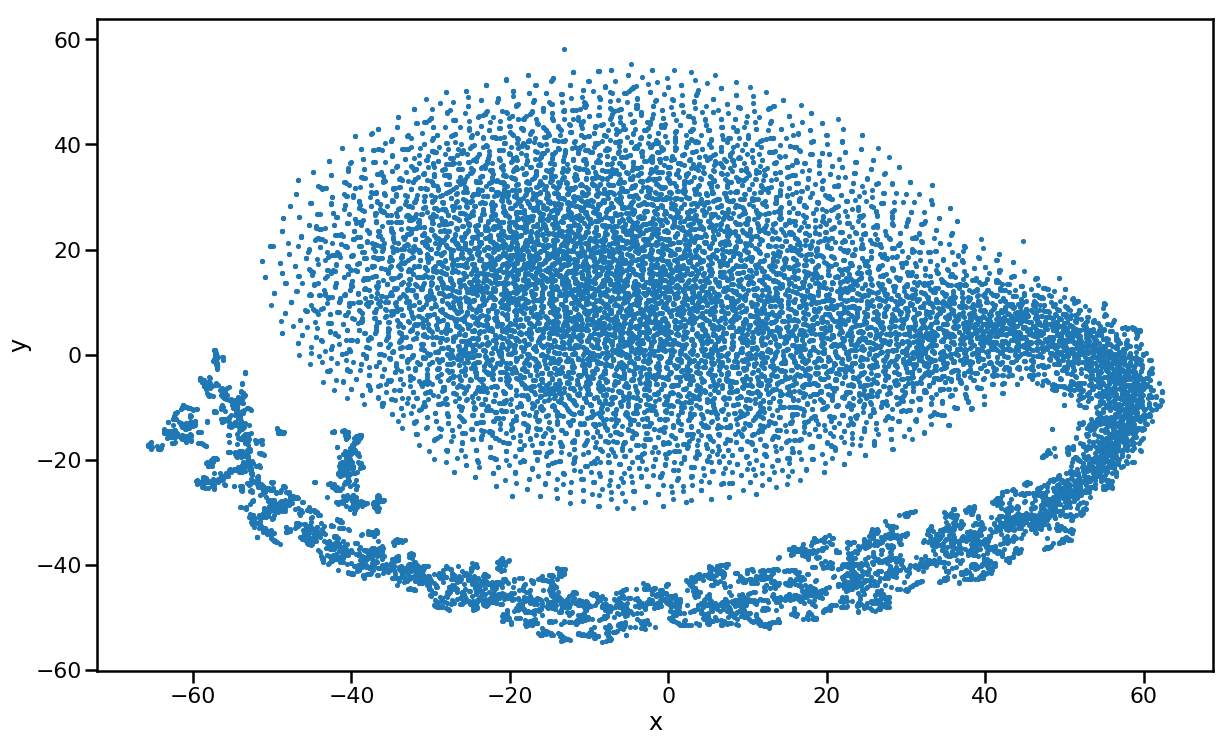

In [25]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [26]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

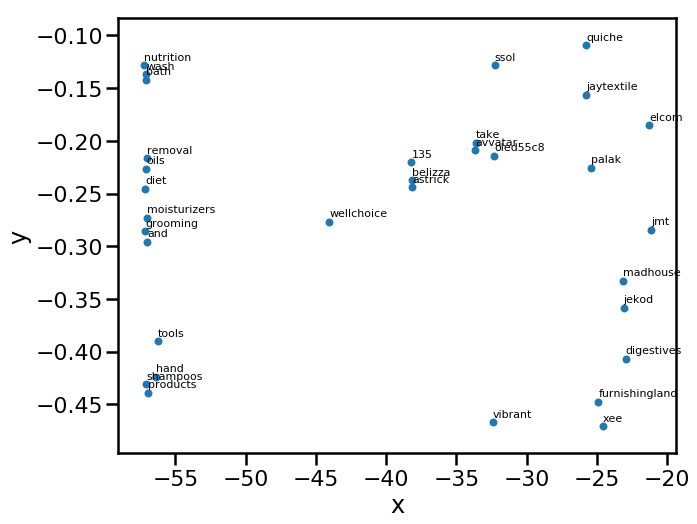

In [27]:
plot_region(x_bounds=(-400.0, -20), y_bounds=(-0.5, -0.1))

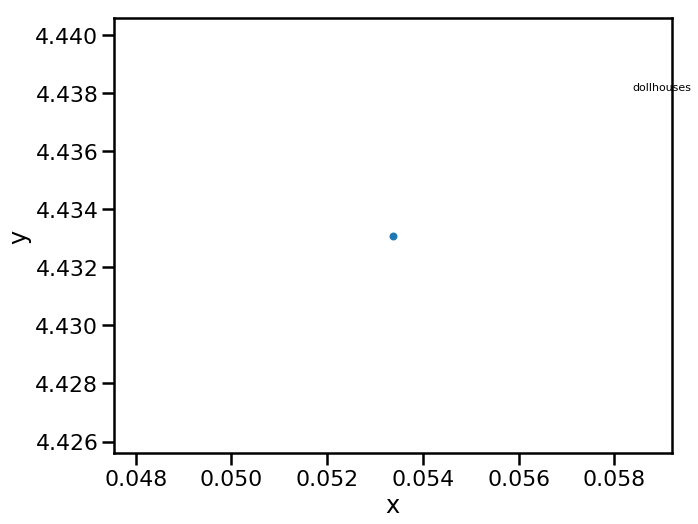

In [28]:
plot_region(x_bounds=(0, 0.2), y_bounds=(4, 4.5))

In [29]:
model.most_similar("clothing")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wear', 0.9809409379959106),
 ('winter', 0.9795283675193787),
 ('western', 0.9795195460319519),
 ('ethnic', 0.9710893034934998),
 ('seasonal', 0.9686759114265442),
 ('t', 0.9642680287361145),
 ('sarees', 0.9635695815086365),
 ('polos', 0.9616280794143677),
 ('kurtas', 0.9564517736434937),
 ('tops', 0.9562751650810242)]

In [30]:
model.most_similar("mobile")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mi', 0.9657032489776611),
 ('apple', 0.9592181444168091),
 ('motorola', 0.937375545501709),
 ('cables', 0.9329887628555298),
 ('mobiles', 0.9281711578369141),
 ('screen', 0.9245321750640869),
 ('tablets', 0.9170631170272827),
 ('wired', 0.9168429374694824),
 ('smartphones', 0.9167819023132324),
 ('electronics', 0.9157824516296387)]

In [31]:
model.most_similar('furniture')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('room', 0.9827463626861572),
 ('dining', 0.9777991771697998),
 ('containers', 0.9736540913581848),
 ('cooling', 0.9693620204925537),
 ('living', 0.9648141860961914),
 ('heating', 0.9640182256698608),
 ('organization', 0.9584258794784546),
 ('geysers', 0.9568558931350708),
 ('bottles', 0.9534085988998413),
 ('heaters', 0.9513324499130249)]

In [32]:
# similar_to_cloth = []
# tmp_list = model.most_similar('clothing')
# for data in tmp_list :
#     similar_to_cloth.append(data[0])

In [33]:
# similar_to_cloth.append('clothing')

In [34]:
# for row in range(len(train_df)) :
#     cnt = False
    
#     for data in similar_to_cloth :
#             if data in str(train_df['breads'][row]) :
#                 cnt = True
            
#     if cnt == False :
#         train_df['label'][row] = 'not clothing'
#     else :
#         train_df['label'][row] = 'clothing'

In [35]:
# train_df.head()

In [36]:
# # train_df.to_csv(r'aarey.csv')
# len(train_df)

In [37]:
# import numpy as np
# from sklearn import svm
# import pandas as pd
# from sklearn.model_selection import train_test_split

# x = np.array(train_df.drop(['label'], axis = 1))
# y = np.array(train_df.drop(['breads'], axis = 1))

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# clf = svm.SVC(kernel = 'linear', gamma = 1)
# clf.fit(x_train, y_train)

# accuracy = clf.score(x_test, x_test)
# print(accuracy)